 # **1. Data Importing and Cleaning** 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv")  

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64


In [4]:
# Drop missing values
df = df.dropna()  

In [5]:
# Check missing values after dropping
print("\nMissing values after:\n", df.isnull().sum())



Missing values after:
 neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64


In [6]:
# Check dataset shape 
print("\nDataset shape", df.shape)


Dataset shape (338171, 9)


In [8]:
# Check for duplicated rows
duplicated_data = df[df.duplicated()]

# Show the duplicated rows
print(duplicated_data)


Empty DataFrame
Columns: [neo_id, name, absolute_magnitude, estimated_diameter_min, estimated_diameter_max, orbiting_body, relative_velocity, miss_distance, is_hazardous]
Index: []


# 2. Exploratory Data Analysis (EDA):

In [9]:
print(df.head())

print(df.info())

print(df.describe())


    neo_id                name  absolute_magnitude  estimated_diameter_min  \
0  2162117  162117 (1998 SD15)               19.14                0.394962   
1  2349507    349507 (2008 QY)               18.50                0.530341   
2  2455415    455415 (2003 GA)               21.45                0.136319   
3  3132126           (2002 PB)               20.63                0.198863   
4  3557844           (2011 DW)               22.70                0.076658   

   estimated_diameter_max orbiting_body  relative_velocity  miss_distance  \
0                0.883161         Earth       71745.401048   5.814362e+07   
1                1.185878         Earth      109949.757148   5.580105e+07   
2                0.304818         Earth       24865.506798   6.720689e+07   
3                0.444672         Earth       78890.076805   3.039644e+07   
4                0.171412         Earth       56036.519484   6.311863e+07   

   is_hazardous  
0         False  
1          True  
2         Fals

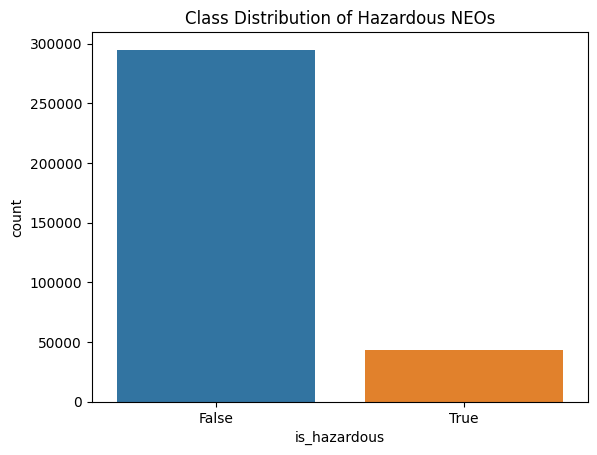

In [10]:
sns.countplot(x='is_hazardous', data=df)
plt.title('Class Distribution of Hazardous NEOs')
plt.show()


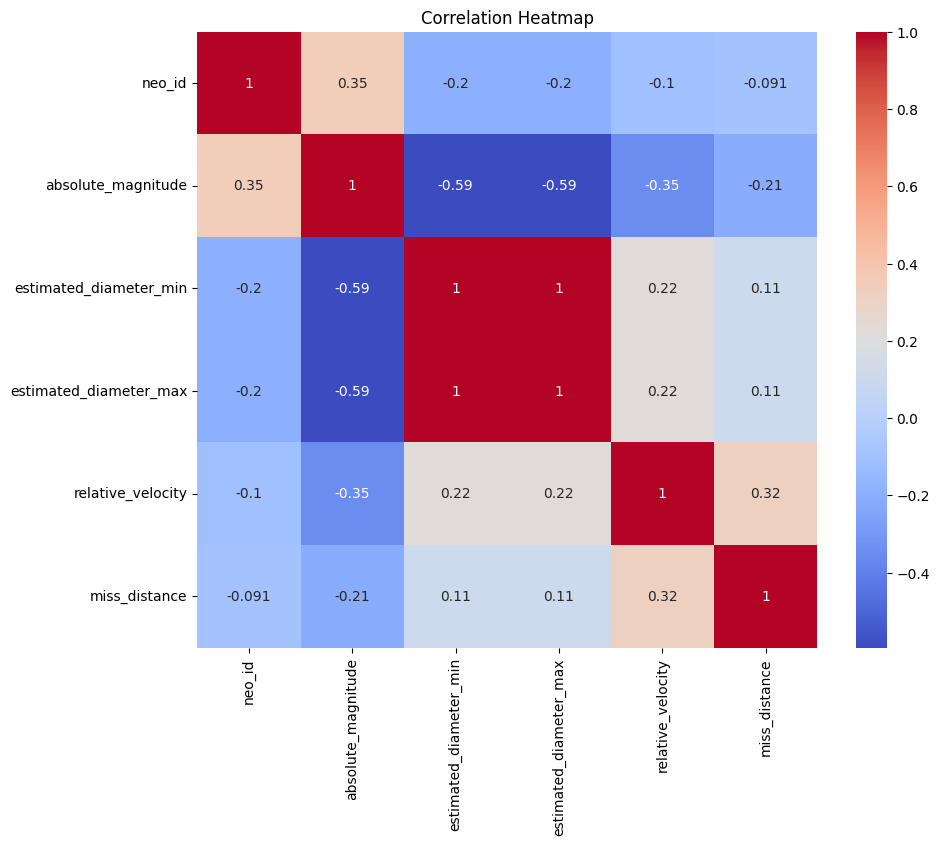

In [11]:
# Select only numeric columns 
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 3. Data Preprocessing

In [13]:
# scaling
scaler = StandardScaler()
df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
    'relative_velocity', 'miss_distance']] = scaler.fit_transform(
    df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
        'relative_velocity', 'miss_distance']])


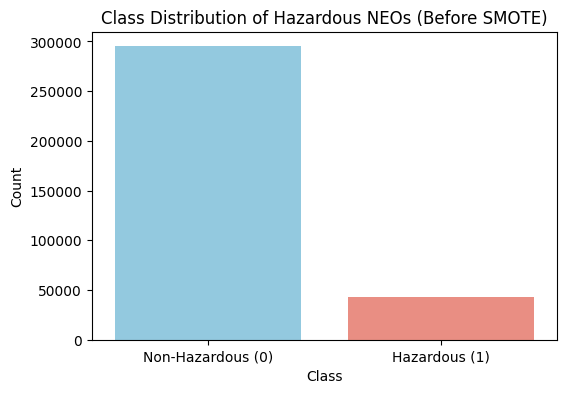

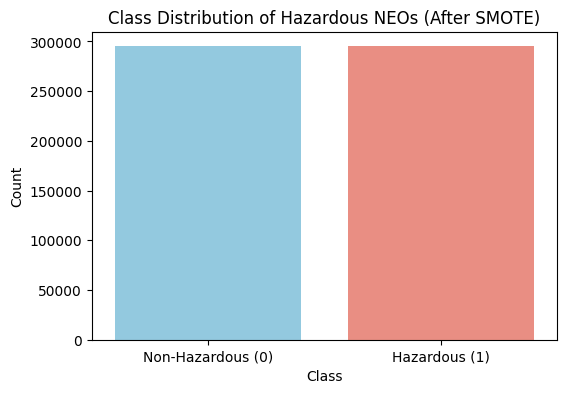

Class distribution after SMOTE (entire dataset):
is_hazardous
0    295009
1    295009
Name: count, dtype: int64


In [17]:
# convert it to integer (0 for False, 1 for True)
df['is_hazardous'] = df['is_hazardous'].astype(int)

# Identify non-numeric columns and handle them (encoding categorical variables)
# Convert string columns to numeric using LabelEncoder 
categorical_columns = df.select_dtypes(include=['object']).columns

# Use LabelEncoder to convert categorical columns to numeric
encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col].astype(str))  
# Plot the class distribution before SMOTE using countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='is_hazardous', data=df, palette=['skyblue', 'salmon'])
plt.title('Class Distribution of Hazardous NEOs (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Hazardous (0)', 'Hazardous (1)'], rotation=0)
plt.show()

# Apply SMOTE to the entire data to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop(columns=['is_hazardous']), df['is_hazardous'])

# Plot the class distribution after SMOTE using countplot
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette=['skyblue', 'salmon'])
plt.title('Class Distribution of Hazardous NEOs (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Hazardous (0)', 'Hazardous (1)'], rotation=0)
plt.show()

# Check the new class distribution after SMOTE
print(f"Class distribution after SMOTE (entire dataset):\n{y_resampled.value_counts()}")



In [19]:
X_resampled = pd.DataFrame(X_resampled, columns=['absolute_magnitude', 'estimated_diameter_min', 
                                                 'estimated_diameter_max', 'relative_velocity', 'miss_distance'])

y_resampled = pd.Series(y_resampled)


In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# 4. Model Training and Evaluation

In [24]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [25]:
# predictions the test 
y_pred = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     59040
           1       0.90      0.96      0.93     58964

    accuracy                           0.92    118004
   macro avg       0.93      0.92      0.92    118004
weighted avg       0.93      0.92      0.92    118004

Confusion Matrix:
 [[52669  6371]
 [ 2595 56369]]
AUC-ROC Score: 0.9742583267643994


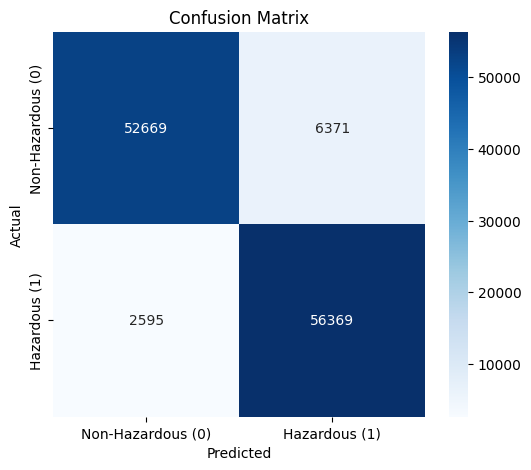

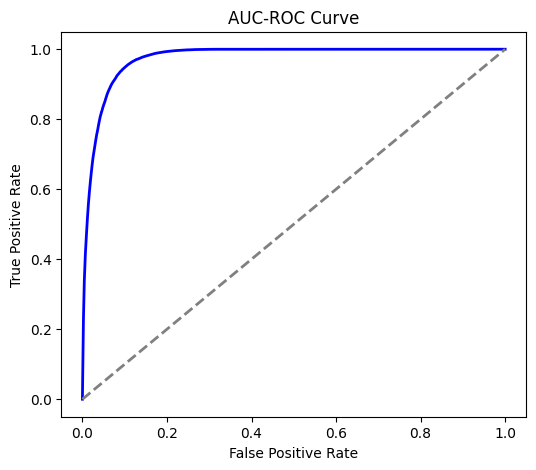

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate and print AUC-ROC score
auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC-ROC Score:", auc_score)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hazardous (0)", "Hazardous (1)"], yticklabels=["Non-Hazardous (0)", "Hazardous (1)"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


use another model to choose the best

In [29]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)


In [30]:
# Train the model
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [31]:
# predictions 
y_pred_logreg = logreg_model.predict(X_test)


Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.85      0.71      0.78     59040
           1       0.75      0.88      0.81     58964

    accuracy                           0.80    118004
   macro avg       0.80      0.80      0.79    118004
weighted avg       0.80      0.80      0.79    118004

Confusion Matrix (Logistic Regression):
 [[42160 16880]
 [ 7255 51709]]
AUC-ROC Score (Logistic Regression): 0.8369716526656568


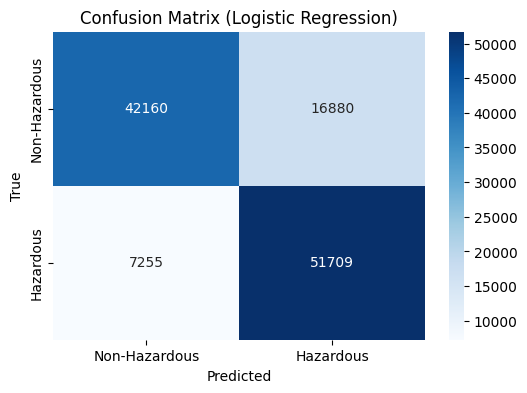

In [32]:
# Evaluate the Logistic Regression model
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg))
print("AUC-ROC Score (Logistic Regression):", roc_auc_score(y_test, logreg_model.predict_proba(X_test)[:, 1]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hazardous', 'Hazardous'], yticklabels=['Non-Hazardous', 'Hazardous'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()